<a href="https://colab.research.google.com/github/ramin40/Variational-Auto-Encoder/blob/main/variational_auto_encoder_with_fashion_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing necessary libraries

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as k


# defining constants

In [2]:
latent_dim=2
batch_size=32
epochs=10
image_size=28
channels=1


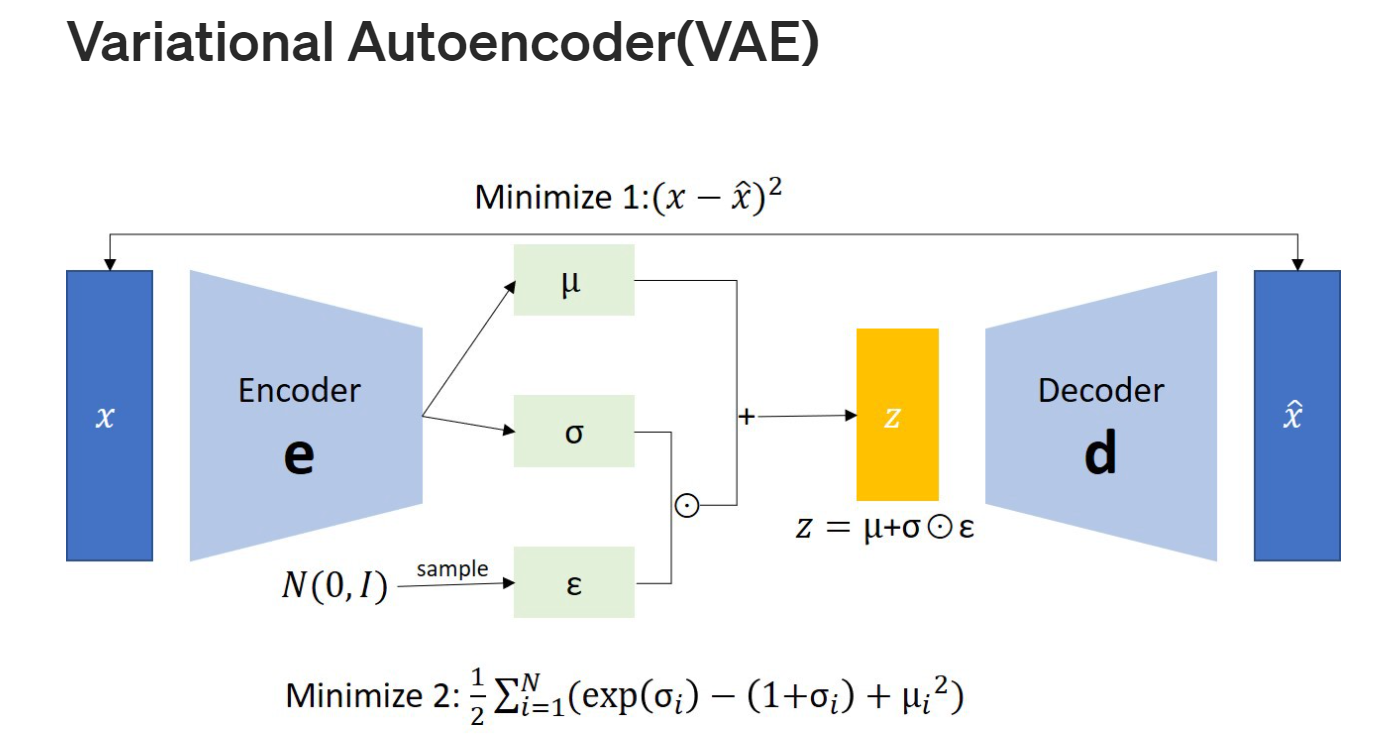


# sampling layer

In [3]:
class Sampling(keras.layers.Layer):
  def __init__(self):
    super(Sampling,self).__init__()
  
  def call(self,inputs):
    mu,log_var=inputs
    #log_var=inputs[1]
    batch=tf.shape(mu)[0]
    dim=tf.shape(mu)[1]
    epsilon=k.random_normal(shape=(batch,dim),mean=0,stddev=1)
    z= mu +tf.exp(0.5*log_var)*epsilon
    return z
sampling_layer=Sampling()

# building the encoder

In [4]:
encoder_input=keras.layers.Input((image_size,image_size,1))
x=keras.layers.Conv2D(32,3,2,padding='same',activation='relu')(encoder_input)
last_encoder_conv=keras.layers.Conv2D(64,3,2,padding='same',activation='relu')(x)
x=keras.layers.Flatten()(last_encoder_conv)
last_encoder_conv_shape=last_encoder_conv.shape
x=keras.layers.Dense(16,activation='relu')(x)
mean_z=keras.layers.Dense(latent_dim)(x)
log_var_z=keras.layers.Dense(latent_dim)(x)
z=sampling_layer([mean_z,log_var_z])
encoder_model=keras.Model(encoder_input,[mean_z,log_var_z,z])
encoder_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# building decoder

In [5]:
height=last_encoder_conv_shape[1]
width=last_encoder_conv_shape[2]
channels=last_encoder_conv_shape[3]
decoder_input=keras.layers.Input(shape=(latent_dim,))
x=keras.layers.Dense(height*width*channels,activation='relu')(decoder_input)
x=keras.layers.Reshape(target_shape=(height,width,channels))(x)
x=keras.layers.Conv2DTranspose(32,3,2,'same',activation='relu')(x)
x=keras.layers.Conv2DTranspose(64,3,2,'same',activation='relu')(x)
x=keras.layers.Conv2DTranspose(1,3,1,'same',activation='sigmoid')(x)
decoder_model=keras.Model(decoder_input,x)
decoder_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         577       
Total params: 46,945
Trainable params: 46,945
Non-trainable params: 0
_______________________________________________________

# building the VAE model

In [6]:
class VAE(keras.models.Model):
  def __init__(self,encoder,decoder):
    super(VAE,self).__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.total_loss=keras.metrics.Mean(name='total loss')
    self.reconstruction_loss=keras.metrics.Mean(name='reconstruction loss')
    self.k_l_loss=keras.metrics.Mean('K_L loss')
  @property
  def metrics(self):
    return([self.total_loss,self.reconstruction_loss,self.k_l_loss])
  
  def train_step(self,data):
    with tf.GradientTape() as tape:
      mean_z,log_var_z,z=self.encoder(data)
      reconstructed=self.decoder(z)
      rec_loss=tf.reduce_mean(
          tf.reduce_sum(
              keras.losses.binary_crossentropy(data,reconstructed),axis=(1,2) ))
      kl_loss = -0.5 * (1 + log_var_z - tf.square(mean_z) - tf.exp(log_var_z))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_losses=kl_loss+rec_loss
    grades=tape.gradient(total_losses,self.trainable_weights)
    self.optimizer.apply_gradients(zip(grades,self.trainable_weights))
    self.total_loss.update_state(total_losses)
    self.reconstruction_loss.update_state(rec_loss)
    self.k_l_loss.update_state(kl_loss)
    return {
            "loss": self.total_loss.result(),
            "reconstruction_loss": self.reconstruction_loss.result(),
            "kl_loss": self.k_l_loss.result(),
        }

In [7]:
from keras.datasets import fashion_mnist

In [11]:
(x_train,_),(x_test,_)=fashion_mnist.load_data()
train_data=tf.concat([x_train,x_test],axis=0)
train_data=tf.cast(tf.expand_dims(train_data,axis=-1),dtype=tf.float32)/255
vae=VAE(encoder_model,decoder_model)
vae.compile(optimizer='adam')
vae.fit(train_data,batch_size=512,epochs=20,)

Epoch 1/20
137/137 [==============================] - 9s 61ms/step - loss: 317.0729 - reconstruction_loss: 309.8065 - kl_loss: 7.2664
Epoch 2/20
137/137 [==============================] - 8s 61ms/step - loss: 272.9674 - reconstruction_loss: 265.0264 - kl_loss: 7.9410
Epoch 3/20
137/137 [==============================] - 8s 61ms/step - loss: 271.7083 - reconstruction_loss: 263.8227 - kl_loss: 7.8857
Epoch 4/20
137/137 [==============================] - 8s 61ms/step - loss: 271.3126 - reconstruction_loss: 263.4170 - kl_loss: 7.8956
Epoch 5/20
137/137 [==============================] - 8s 61ms/step - loss: 271.4852 - reconstruction_loss: 263.6660 - kl_loss: 7.8191
Epoch 6/20
137/137 [==============================] - 8s 61ms/step - loss: 271.3847 - reconstruction_loss: 263.5306 - kl_loss: 7.8541
Epoch 7/20
137/137 [==============================] - 8s 61ms/step - loss: 271.1953 - reconstruction_loss: 263.3970 - kl_loss: 7.7983
Epoch 8/20
137/137 [==============================] - 8s 61ms/

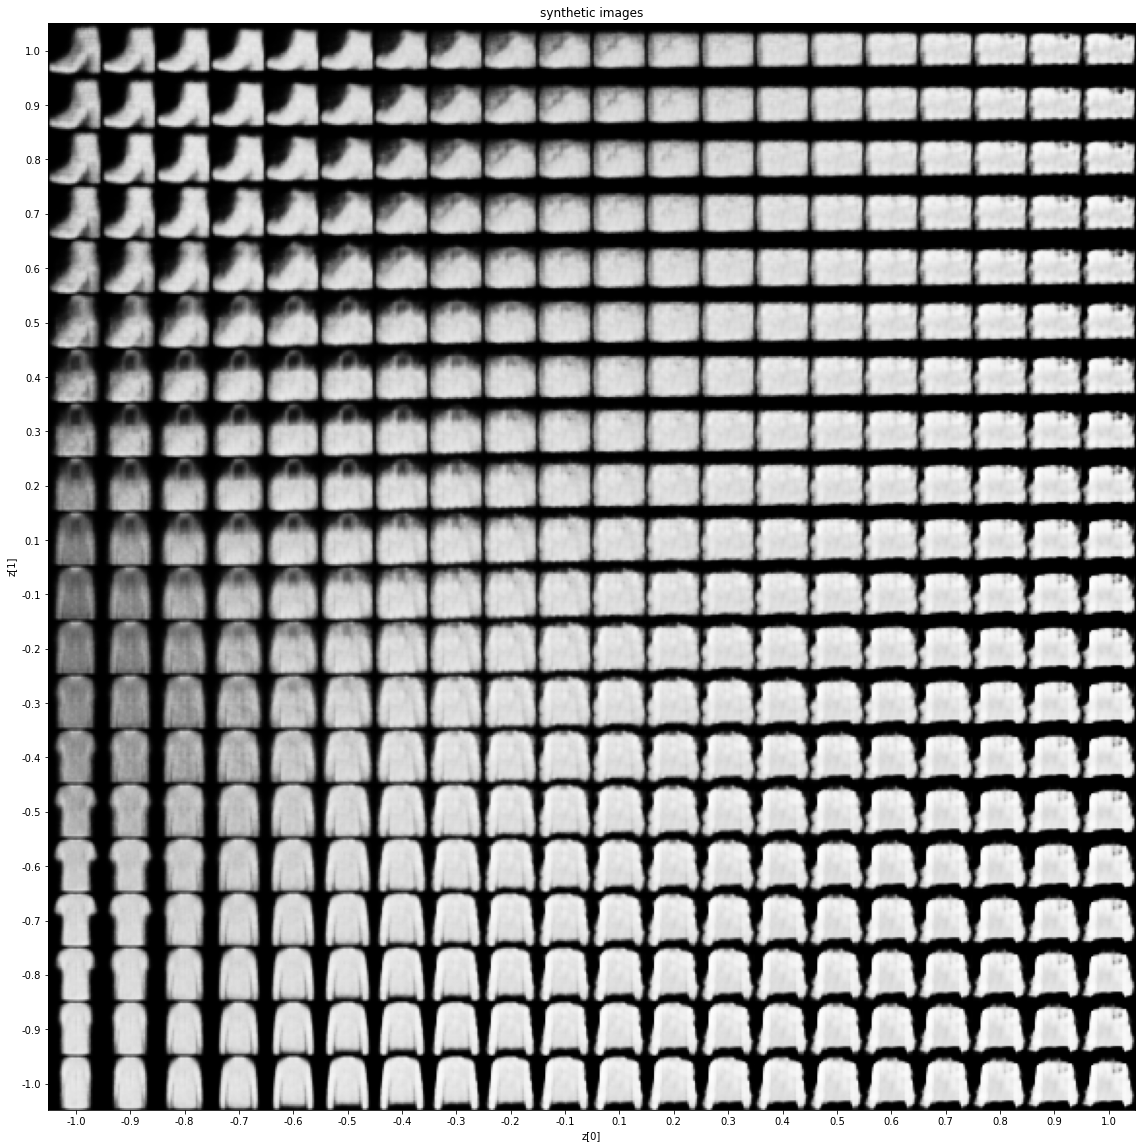

In [20]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=20, figsize=20):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.title('synthetic images')
    plt.savefig('synthetic images from VAE',dpi=200)
    plt.show()



plot_latent_space(vae)

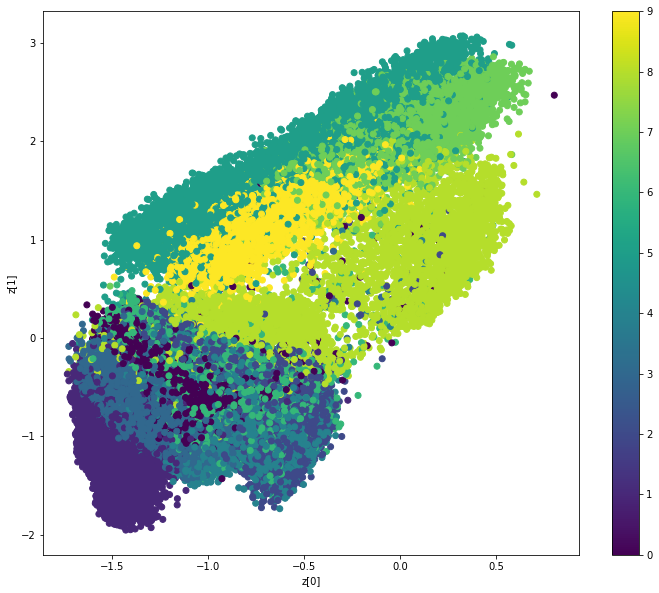

In [18]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig("distribution of VAE's input ",dpi=500)
    plt.show()


(x_train, y_train), _ = fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)


In [ ]:
vae.predict(train_data)